If you found any bugs in this ipython notebook, please contact qiuwch@gmail.com  
If there's an error say "something is undefined", please run cell which contains the definition or use "menu -> cell -> run all above"

# Initialization

In [1]:
# Import python library for this notebook
import numpy as np # fundamental package for scientific computing
import matplotlib.pyplot as plt # package for plot function

import sys
sys.path.append("/home/jovyan/")
from imtools import load_img, show_img, show_hist, resize_img
img = load_img("bearing_scrached_fuji_tunnel.jpg")


# show figures inline
%matplotlib inline 

def myimshow(I, **kwargs):
    # utility function to show image
    plt.figure();
    plt.axis('off')
    plt.imshow(I, cmap=plt.gray(), **kwargs)

# Generate sinusoid stimuli

Sinusoid $ I(\mathbf{x}) = A \cos(\mathbf{\omega} \mathbf{x} + \rho) $

$ A $ is the amplitude, $ \rho $ is the phase, and $ \mathbf{\omega} $ is the frequency.

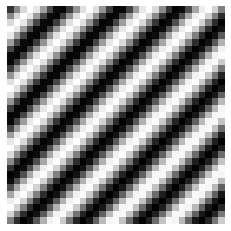

In [2]:
def genSinusoid(sz, A, omega, rho):
    # Generate Sinusoid grating
    # sz: size of generated image (width, height)
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1)) # a BUG is fixed in this line

    stimuli = A * np.cos(omega[0] * x  + omega[1] * y + rho)
    return stimuli

theta = np.pi/4
omega = [np.cos(theta), np.sin(theta)]
sinusoidParam = {'A':1, 'omega':omega, 'rho':np.pi/2, 'sz':(32,32)}
myimshow(genSinusoid(**sinusoidParam)) 
# ** is a special syntax in python, which enables passing a key-value dictionary as parameter

# Generate gabor filter
A general type of Gabor filter[1] can be defined:  
$$ g(x,y;\lambda,\theta,\psi,\sigma,\gamma) = \exp\left(-\frac{x'^2+\gamma^2y'^2}{2\sigma^2}\right)\exp\left(i\left(2\pi\frac{x'}{\lambda}+\psi\right)\right) $$
[1] https://en.wikipedia.org/wiki/Gabor_filter  

Here we implement a type of Gabor filter which satisfies the neurophysiological constraints for simple cells:   
$$ \psi (x; \omega, \theta, K) = \left[\frac{\omega^2}{ 4 \pi K^2} \exp  \{-(\omega^2/8K^2)[4(x\cdot(cos\theta, sin\theta))^2 + (x \cdot ( -sin \theta, cos \theta))^2]\} \right] \times \left[ \exp \{ iwx \cdot (cos\theta, sin\theta) \} exp(K^2/2) \right] $$

1.5140274644582012e-05

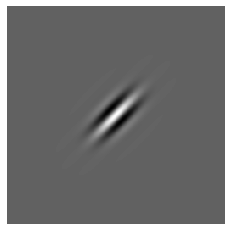

In [3]:
def genGabor(sz, omega, theta, func=np.cos, K=np.pi):
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)
    
    gauss = omega**2 / (4*np.pi * K**2) * np.exp(- omega**2 / (8*K**2) * ( 4 * x1**2 + y1**2))
#     myimshow(gauss)
    sinusoid = func(omega * x1) * np.exp(K**2 / 2)
#     myimshow(sinusoid)
    gabor = gauss * sinusoid
    return gabor
        
g = genGabor((256,256), 0.3, np.pi/4, func=np.cos) 
# change func to "cos", "sin" can generate sin gabor or cos gabor, here we pass a function name as a parameter
myimshow(g)
np.mean(g)

# Interactive: Gabor demo
If you evaluate the next cell in your computer, you can see an interactive demo like this.  
<img src="../data/gabor/snapshot.png">

**Drag the slider to change parameters, and see the change of gabor filter.**

In [4]:
from IPython.html.widgets import interact, interactive, fixed
def demoGabor(theta, omega):
    myimshow(genGabor((128,128), omega, theta))
interact(demoGabor, theta=(0,np.pi,np.pi/8), omega=(0.1,1,0.1))

/opt/conda/lib/python3.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(FloatSlider(value=1.5707963267948966, description='theta', max=3.141592653589793, step=0…

<function __main__.demoGabor(theta, omega)>

# Generate gabor filter bank

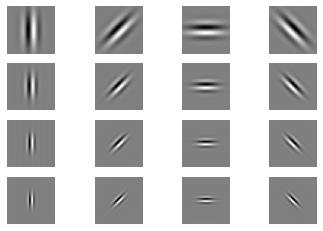

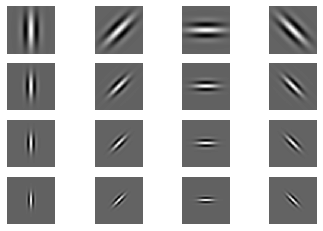

In [5]:
theta = np.arange(0, np.pi, np.pi/4) # range of theta
omega = np.arange(0.2, 0.6, 0.1) # range of omega
params = [(t,o) for o in omega for t in theta]
sinFilterBank = []
cosFilterBank = []
gaborParams = []
for (theta, omega) in params:
    gaborParam = {'omega':omega, 'theta':theta, 'sz':(128, 128)}
    sinGabor = genGabor(func=np.sin, **gaborParam)
    cosGabor = genGabor(func=np.cos, **gaborParam)
    sinFilterBank.append(sinGabor)
    cosFilterBank.append(cosGabor)
    gaborParams.append(gaborParam)

plt.figure()
n = len(sinFilterBank)
for i in range(n):
    plt.subplot(4,4,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(sinFilterBank[i])

plt.figure()
for i in range(n):
    plt.subplot(4,4,i+1)
    # title(r'$\theta$={theta:.2f}$\omega$={omega}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(cosFilterBank[i])

# Apply filter bank to zebra image

CPU times: user 8.26 s, sys: 44 ms, total: 8.31 s
Wall time: 8.44 s


<Figure size 432x288 with 0 Axes>

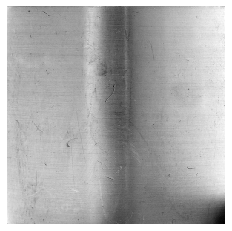

<Figure size 432x288 with 0 Axes>

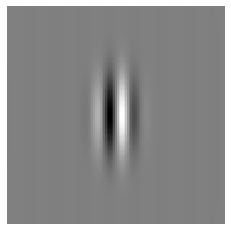

<Figure size 432x288 with 0 Axes>

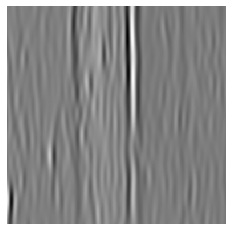

In [9]:
from skimage.color import rgb2gray
from scipy.signal import convolve2d
zebra = img
plt.figure(); myimshow(zebra)
sinGabor = sinFilterBank[8] 
plt.figure(); myimshow(sinGabor)
%time res = convolve2d(zebra, sinGabor, mode='valid') # Will take about one minute
plt.figure(); myimshow(res); # title('response') Book figure

"Zebra running Ngorongoro" by Muhammad Mahdi Karim (www.micro2macro.net)

For examples of filters applied to texture processing see: http://scikit-image.org/docs/dev/auto_examples/plot_gabor.html

# Exercise 1.1
Apply Gabor filters to the zebra image. Adjust the frequency and orientation of the Gabors to find the horizontal and vertical stripes. Plot the output. Can you also find Gabors that respond to the legs?

# Quadrature pair, simple/complex cell

Text(0.5, 1.0, 'Resp. of complex cell')

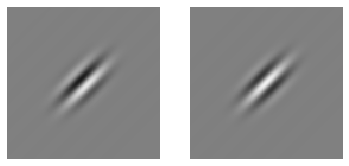

<Figure size 432x288 with 0 Axes>

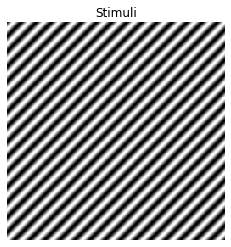

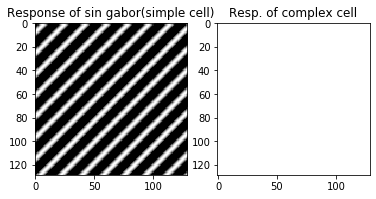

In [7]:
theta = np.pi/4
sinGabor = genGabor((129,129), 0.4, theta, np.sin)
cosGabor = genGabor((129,129), 0.4, theta, np.cos)
plt.figure(); 
plt.subplot(121); plt.axis('off'); plt.imshow(sinGabor, vmin=-0.2, vmax=0.2)
plt.subplot(122); plt.axis('off'); plt.imshow(cosGabor, vmin=-0.2, vmax=0.2)

theta = np.pi/4 + np.pi
sinusoid = genSinusoid((256,256), 1, (omega*np.sin(theta), omega*np.cos(theta)), 0)
plt.figure(); myimshow(sinusoid); plt.title('Stimuli')

response = convolve2d(sinusoid, sinGabor, mode='valid')
response2 = convolve2d(sinusoid, cosGabor, mode='valid')

plt.figure(); 
plt.subplot(121); plt.imshow(response, vmin=0); plt.title('Response of sin gabor(simple cell)')
plt.subplot(122); plt.imshow(response**2 + response2**2, vmin=0); plt.title('Resp. of complex cell')

**Complex cell is tuned to frequency and less sensitive to phase change**

# Exercise 1.2: Find parameter of an unknown gabor filter
Find the tuning curve of an idealized neuron by measuring its response to different sinusoids. The neuron is a Gabor function so you need to find its preferred orientation, phase, and K. Use equations (3) and (4) from Lecture Notes 2 if you want.

In [10]:
import pickle
# The parameter of this gabor(cell) is unknown
# Try to find its parameter:
unknownGabor = pickle.load(open('../data/gabor/unknownGabor.data', 'rb'))
plt.figure(); myimshow(unknownGabor)

# You can use sinusoid as a stimuli
# For example:
rho = np.pi/2
omega = 0.3
theta = np.pi/2
sinusoid = genSinusoid(unknownGabor.shape, 1, (omega*np.cos(theta), omega*np.sin(theta)), rho)
plt.figure(); myimshow(sinusoid)
response = convolve2d(sinusoid, unknownGabor, mode='valid')
print('Strength of response:', response)

FileNotFoundError: [Errno 2] No such file or directory: '../data/gabor/unknownGabor.data'

# Demo: Gaussian, Laplacian of Gaussian

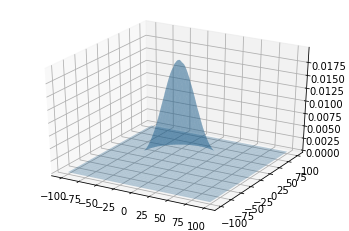

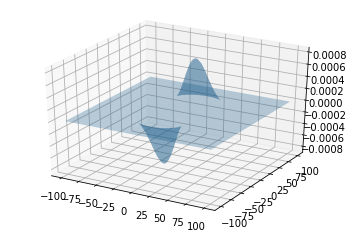

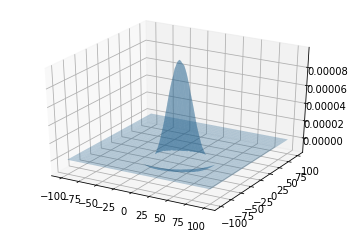

In [12]:
# Utility function to plot 3D surface
def surf(X, Y, Z, **kargs): 
    # Plot 3D data as surface, similar to surf(X,Y,Z) of http://www.mathworks.com/help/matlab/ref/surf.html
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, **kargs)
    
sigma = 20
from mpl_toolkits.mplot3d import Axes3D

[X, Y] = np.meshgrid(np.arange(-100, 101), np.arange(-100, 101))
Z = 1/(np.sqrt(2.0 * np.pi) * sigma) * np.exp(-(X**2+Y**2)/(2.0*sigma**2))

dx = np.roll(Z, 1, axis=1) - Z
dx2 = np.roll(dx, 1, axis=1) - dx

dy = np.roll(Z, 1, axis=0) - Z
dy2 = np.roll(dy, 1, axis=0) - dy

LoG = -(dx2+dy2)

surf(X, Y, Z, alpha=0.3)
# title('Gaussian')

surf(X, Y, dx + dy, alpha=0.3)
# title('First order derivative')

surf(X, Y, LoG, alpha=0.3)
# title('Second order derivative (Laplacian of Gaussian)')

# Exercise 1.3  Find the parameter of Laplacian of Gaussian

1. Briefly describe in words what is a quadrature pair and the difference between simple and complex cells.
3. Find the parameter $\sigma$ of a Laplacian of Gaussian filter by measuring its response to different sinusoids.  
Use equation in Section 2.3 from Lecture Notes 2 if you want.

In [14]:
import pickle

unknownLoG = pickle.load(open('../data/gabor/unknownLoG.data', 'rb'))
plt.figure(); myimshow(unknownLoG)
[X, Y] = np.meshgrid(np.arange(-100, 101), np.arange(-100, 101))
surf(X, Y, unknownLoG, alpha=0.3)

# You can use sinusoid as a stimuli
# For example:
rho = np.pi/2
omega = 0.4
theta = np.pi/6
sinusoid = genSinusoid(unknownLoG.shape, 1, (omega*np.cos(theta), omega*np.sin(theta)), rho)
plt.figure(); myimshow(sinusoid)
response = convolve2d(sinusoid, unknownLoG, mode='valid')
print('Strength of response:', response)

FileNotFoundError: [Errno 2] No such file or directory: '../data/gabor/unknownLoG.data'